In [9]:
import numpy as np
import pandas as pd
import os
import multiprocessing
#import stuff and define functions
from typing import Dict, List, Optional, Union
from pathlib import Path
from sklearn.decomposition import IncrementalPCA, PCA
from CustomFunctions import shapePCAtools, file_management, shparam_mod
import math
from vtk.util import numpy_support
import vtk
from aicsshparam import shtools
import pickle as pk


In [10]:
#directories for opening and saving pca stuff
basedir = 'E:/Aaron/Combined_37C_Confocal_PCA_s5_LLS_Apply/'
savedir = basedir + 'Data_and_Figs/'
if not os.path.exists(savedir):
    os.makedirs(savedir)

In [11]:
############# gather data from all experiments ###############
# get the datasets to be combined
datasets = [x for x in os.listdir(savedir) if 'Shape_Metrics' in x]
exlists = [x for x in os.listdir(savedir) if 'ListToExclude' in x]

#### open shape metrics and include bad SH cells
smlst = []
for d in range(len(datasets)):
    #open shape metrics
    sm = pd.read_csv(savedir + datasets[d], index_col = 0)
    #open the list of cells to exclude
    excludes = pd.read_csv(savedir + exlists[d], index_col=0)
    list_to_exclude = [i.replace('_segmented.tiff', '') for i in excludes.iloc[:,0].to_list()]
    sm = sm.loc[[x for x in sm.index if x not in list_to_exclude]]
    smlst.append(sm)
smdf = pd.concat(smlst)
    
    
#open all of the other metrics from the single csv files
if __name__ == '__main__':
    pool = multiprocessing.Pool(processes=60)
    csvlist = [basedir + 'processed_data/' + i +'_cell_info.csv' for i in smdf.cell.to_list()]
    celllist = pool.map(file_management.multicsv, csvlist)
    pool.close()
    pool.join()
cellinfo = pd.concat(celllist)


### make dataframes and merge    
llsdf = smdf.merge(cellinfo.drop(columns=['image', 'cropx (pixels)',
       'cropy (pixels)', 'cropz (pixels)']), left_on = 'cell', right_on = 'cell')

In [12]:
########### FILTER THE DATA A BIT ###############
print(len(llsdf))

############# filter out shape outliers #############
llsdf = llsdf[llsdf.Cell_Volume > 458]
llsdf = llsdf[llsdf.Cell_SurfaceArea < 1700]
print(len(llsdf))

############## filter out speed outliers #############
### these seem to come from segmentation failures that move the cell centroid
llsdf = llsdf[llsdf.speed < 1.3]
# df = df.drop(df[df.isin(df[df.speed>1.3].CellID.unique()).any(axis=1)].index).reset_index(drop=True)
print(len(llsdf))

############# filter out 20240528 ##############
llsdf = llsdf[~llsdf.cell.str.contains('20240528', na=False)]
print(len(llsdf))

########### filter out all but the cells that I followed for 1hr #########
longcells = [i for i, x in llsdf.groupby('CellID') if len(x)>360]
llsdf = llsdf[llsdf.CellID.isin(longcells)]
#also filter out the one cell I followed that got stuck
llsdf = llsdf[llsdf.CellID != '20240527_488_EGFP-CAAX_640_SPY650-DNA_cell3_01']
print(len(llsdf))

#### make sure to reset the index after dropping all of the stuff
llsdf = llsdf.reset_index(drop=True)

15141
15063
14648
14648
8610


In [ ]:
############# optionally scale volumes to match confocal data
# open confocal pca model
confocaldir = "E:/Aaron/Combined_37C_Confocal_PCA_smooth/Data_and_Figs/"
pca = pk.load(open(confocaldir+"pca.pkl",'rb')) 
#open confocal cell stats
condf = pd.read_csv(confocaldir+'Shape_Metrics_with_PCs.csv', index_col=0)

##### scale LLS volumes to confocal volumes
#get volume ratio
vrat = condf.Cell_Volume.mean()/llsdf.Cell_Volume.mean()

#actually rescale and get new coeffs
meshlist = ['E:/Aaron/random_lls_smooth/Meshes/'+x+'_cell_mesh.vtp' for x in llsdf.cell.to_list()]
if __name__ == "__main__":
    with multiprocessing.Pool(processes=60) as pool:
        results = []
        for m in meshlist:
            result = pool.apply_async(shparam_mod.read_mesh_rescale_shcoeffs, args=(
                                        m,
                                        vrat,
                                        vrat,
                                        lmax,
                                        ))
            results.append(result)
        results = [r.get() for r in results]
newcoeffs = pd.DataFrame(results)

#remove old coeffs
llsdf = llsdf.drop(columns=[x for x in llsdf.columns.to_list() if 'shcoeffs' in x])
#replace with new coeffs
llsdf = llsdf.merge(newcoeffs, left_on='cell', right_on='cell')

In [14]:
######### Perform PCA and divide cells into shape space bins ################

#specify number of PCs and number of bins
npcs = 10
nbins = 5
bins = list(range(1,nbins+1))
lmax = 10

# open confocal pca model
confocaldir = "E:/Aaron/Combined_37C_Confocal_PCA_s5/Data_and_Figs/"
pca = pk.load(open(confocaldir+"pca.pkl",'rb')) 


# tranform the LLS data
lls_coeff = llsdf[[x for x in llsdf.columns.to_list() if 'shcoeffs' in x]]
lls_transform = pca.transform(lls_coeff)

# Dataframe of transformed variable
pc_names = [f"Cell_PC{c}" for c in range(1, 1 + npcs)]
df_trans = pd.DataFrame(data=lls_transform, columns=pc_names, index = lls_coeff.index)


# Adjust the sign of PCs so that larger cells are represent by positive values
#need actual volume data to do this so needs to be combined with shape metrics
df_trans['Cell_Volume'] = llsdf.Cell_Volume
for pcid, pc_name in enumerate(pc_names):
    pearson = np.corrcoef(df_trans.Cell_Volume.values, df_trans[pc_name].values)
    if pearson[0, 1] < 0:
        df_trans[pc_name] *= -1
        pca.components_[pcid] *= -1
df_trans = df_trans.drop(columns = 'Cell_Volume')


########## flip PC1 so that the flux is clockwise
flipind = 0
df_trans[pc_names[flipind]] *= -1
pca.components_[flipind] *= -1


##### digitize shape mode and also filter extremes
df_dig = pd.DataFrame(index = df_trans.index)
for count, col in enumerate(df_trans.columns.to_list()):
    df_digit, bin_indexes, (bin_centers, pc_std) = shapePCAtools.digitize_shape_mode(
        df = df_trans,
        feature = col,
        nbins = nbins,
        filter_based_on = df_trans.columns.to_list(),
        filter_extremes_pct = float(1),
        save = None,
        return_freqs_per_structs = False
    )
    #put bin_indexes into a larger list that I can later iterate through
    df_dig = df_dig.merge(df_digit[[col,'bin']], left_index = True, right_index = True)
    df_dig = df_dig.rename(columns={'bin':f'PC{count+1}_bins'})


######### add PCs to big data frame
llsdf = llsdf.merge(df_dig[pc_names], left_index = True, right_index = True)
        

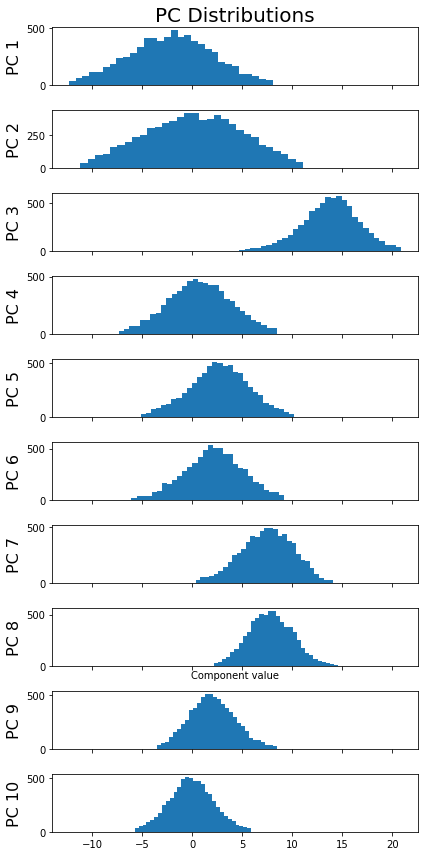

In [15]:
##################### PCA relevant figures #######################


########### plot distributions of PCs ###################
import matplotlib.pyplot as plt
fig, axes = plt.subplots(10, 1, figsize=(6,12), sharex=True)
for i, ax in enumerate(axes[:]):
    ax.hist(llsdf[pc_names].iloc[:,i].values, 30)
# for i, ax in enumerate(axes[:,1]):
#     ax.hist(nuc_weights[:,i], 30, (-2,2))
    
axes[0].set_title("PC Distributions", fontsize = 20)
# axes[0,1].set_title("Nucleus Distributions", fontsize = 20)
[ax.set_ylabel("PC %i"%(i+1), fontsize = 16) for i, ax in enumerate(axes[:])];
axes[7].set_xlabel("Component value")

plt.tight_layout()
plt.savefig(savedir+ 'PC distributions.png', bbox_inches='tight')





# #pre-volume adjusted PCs
# origdf = smdf.merge(atidf.drop(columns=['image', 'cropx (pixels)',
#        'cropy (pixels)', 'cropz (pixels)']), left_on = 'cell', right_on = 'cell')
# origdf = origdf[origdf.Cell_Volume > 458]
# origdf = origdf[origdf.Cell_SurfaceArea < 1700]
# origdf = origdf[origdf.speed < 1.3]
# origdf = origdf[~origdf.cell.str.contains('20240528', na=False)].reset_index(drop=True)
# longcells = [i for i, x in origdf.groupby('CellID') if len(x)>360]
# origdf = origdf[origdf.CellID.isin(longcells)]
# # tranform the LLS data
# orig_coeff = origdf[[x for x in origdf.columns.to_list() if 'shcoeffs' in x]]
# orig_transform = pca.transform(orig_coeff)
# # Dataframe of transformed variable
# pc_names = [f"Cell_PC{c}" for c in range(1, 1 + npcs)]
# orig_trans = pd.DataFrame(data=orig_transform, columns=pc_names, index = orig_coeff.index)
# # orig_trans['Cell_Volume'] = origdf.Cell_Volume
# # for pcid, pc_name in enumerate(pc_names):
# #     pearson = np.corrcoef(orig_trans.Cell_Volume.values, orig_trans[pc_name].values)
# #     if pearson[0, 1] < 0:
# #         orig_trans[pc_name] *= -1
# #         pca.components_[pcid] *= -1
# # orig_trans = orig_trans.drop(columns = 'Cell_Volume')


# ########### plot distributions of PCs ###################
# import matplotlib.pyplot as plt
# fig, axes = plt.subplots(10, 1, figsize=(6,12), sharex=True)
# for i, ax in enumerate(axes[:]):
#     ax.hist(df_trans[pc_names].iloc[:,i].values, 30, density = True,alpha = 0.7, label = 'volume adjusted')
#     ax.hist(orig_trans[pc_names].iloc[:,i].values, 30, density = True,alpha = 0.7, label = 'original')
#     ax.hist(condf[pc_names].iloc[:,i].values, 30, density = True,alpha = 0.7, label = 'confocal')
# axes[0].set_title("PC Distributions", fontsize = 20)
# # axes[0,1].set_title("Nucleus Distributions", fontsize = 20)
# [ax.set_ylabel("PC %i"%(i+1), fontsize = 16) for i, ax in enumerate(axes[:])];
# axes[-1].set_xlabel("Component value")
# ax.legend()
# plt.tight_layout()
# plt.savefig(savedir+ 'PC distributions.png', bbox_inches='tight')



In [16]:
############# BIN PCs TO USE IN CGPS ###################

nbins = 11


#remove the "Cell_" from PCs
for x in llsdf.columns.to_list():
    if 'PC' in x:
        llsdf = llsdf.rename(columns = {x:x.replace('Cell_','')})



pclist = [x for x in llsdf.columns.to_list() if 'PC' in x]
centers = []
for count, col in enumerate(pclist):
    df_digit, bin_indexes, (bin_centers, pc_std) = shapePCAtools.digitize_shape_mode(
        df = llsdf,
        feature = col,
        nbins = nbins,
        filter_based_on = pclist,
        filter_extremes_pct = 0,
        save = None,
        return_freqs_per_structs = False,
    )
    #put bin_indexes into a larger list that I can later iterate through
    llsdf[f'PC{count+1}bins'] = df_digit.bin
    #get bin centers for each PC
    centers.append(pd.Series(bin_centers*pc_std, name=col))
centers = pd.DataFrame(centers).T
centers.to_csv(savedir+'PC_bin_centers.csv')


################ add all of the different classifiers to the dataset
treat = []
experiment = []
date = []

for f, m in zip(llsdf['cell'].to_list(), llsdf['frame'].to_list()):
    if 'CK666' in f:
        treat.append('CK666')
        experiment.append('Drug')
    elif 'ParaNitroBleb' in f:
        treat.append('Para-Nitro-Blebbistatin')
        experiment.append('Drug')
    elif 'DMSO' in f:
        treat.append('DMSO')
        experiment.append('Drug')
    else:
        treat.append('Random')
        experiment.append('Random')

            
    #get the date and experiment number on that date
    spl = f.split('_')
    date.append(spl[0])

llsdf['Date'] = date
llsdf['Treatment'] = treat
llsdf['Experiment'] = experiment
            

llsdf.to_csv(savedir + 'All_Data_with_CGPS_bins.csv')
print('Calculated combined PCs and binned PCs')

Calculated combined PCs and binned PCs
